## CNN to discriminate AD and MCI

In [1]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Data Structure**

These are the types of images we want CNN to differentiate:

* AD (Alzheimer's Disease):

Image dimensions: (256, 256)


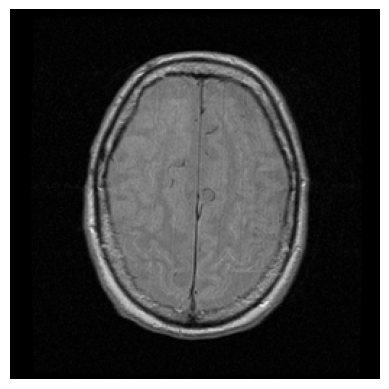

In [2]:
import pydicom

file=pydicom.dcmread("AD_ADNI/ADNI_002_S_0619_MR_Axial_PD_T2_FSE__br_raw_20060605133208913_25_S15207_I16494.dcm")

if 'PixelData' in file: # Checking if the DICOM file contains image pixel data by verifying the presence of 'PixelData' attribute
    image = file.pixel_array  
    print("Image dimensions:", image.shape)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off') 
    plt.show()

* MCI (Mild Cognitive Impairment):

Image dimensions: (256, 256)


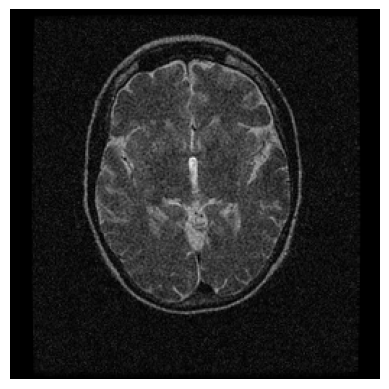

In [3]:
file=pydicom.dcmread("MCI_ADNI/ADNI_002_S_0729_MR_Axial_PD_T2_FSE__br_raw_20070225110135421_44_S27090_I41587.dcm")

if 'PixelData' in file: # Checking if the DICOM file contains image pixel data by verifying the presence of 'PixelData' attribute
    image = file.pixel_array  
    print("Image dimensions:", image.shape)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.axis('off') 
    plt.show()

**Building Input**

* X (input)

In [4]:
matrices_folder_path_AD = "Matrix_AD"
matrices_folder_path_MCI = "Matrix_MCI"

In [5]:
# Function to load matrices from a folder
def load_matrices(folder_path):
    file_names = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    
    all_pixel_arrays = []
    
    for file_name in file_names:
        file_path = os.path.join(folder_path, file_name)
        
        pixel_array = np.load(file_path)
        
        all_pixel_arrays.append(pixel_array)
    
    return np.array(all_pixel_arrays)

In [6]:
# Load the matrices for AD and MCI separately
tensor_AD = load_matrices(matrices_folder_path_AD)
tensor_MCI = load_matrices(matrices_folder_path_MCI)

In [7]:
print("Dimensions of AD tensor:", tensor_AD.shape)
print("Dimensions of MCI tensor:", tensor_MCI.shape)

Dimensions of AD tensor: (225, 256, 256)
Dimensions of MCI tensor: (144, 256, 256)


In [8]:
# Concatenate the tensors for AD and MCI
all_data = np.concatenate((tensor_AD, tensor_MCI), axis=0)

* Y (output)

In [9]:
# Create labels for AD and MCI (0 for AD, 1 for MCI)
labels_AD = np.zeros((tensor_AD.shape[0],), dtype=int)
labels_MCI = np.ones((tensor_MCI.shape[0],), dtype=int)

In [10]:
# Concatenate the labels
all_labels = np.concatenate((labels_AD, labels_MCI), axis=0)

* Randomize X and Y

In [11]:
# Randomize data and labels while maintaining their correspondence
perm = np.random.permutation(all_data.shape[0])
all_data = all_data[perm]
all_labels = all_labels[perm]

In [12]:
# Check data dimensions and labels
print("Dimensiones de los datos:", all_data.shape)
print("Dimensiones de las etiquetas:", all_labels.shape)

Dimensiones de los datos: (369, 256, 256)
Dimensiones de las etiquetas: (369,)


In [13]:
from sklearn.model_selection import train_test_split

# Split the data and labels into training and test sets
x_train, x_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

In [14]:
from keras.utils import to_categorical
num_classes = 2

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

2024-04-30 09:30:00.354044: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-30 09:30:00.356239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 09:30:00.403381: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-30 09:30:00.404040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-30 09:30:02.241846: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [15]:
# Check the shapes of training and testing data sets and labels
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (295, 256, 256)
y_train shape: (295, 2)
x_test shape: (74, 256, 256)
y_test shape: (74, 2)


**CNN bulding**

* CNN model

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

model = Sequential()  # creating the model
model.add(Conv2D(32, kernel_size=(3, 3),  # nº filters=32, kernel size=(3,3)
     activation='relu', #activation function= ReLU
     input_shape=(256, 256, 1))) # this specifies the way images are input to the layer, dimensions of the input=(row, col, channel input)

model.add(Conv2D(64, (3, 3), activation='relu')) # convolutional layer
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling layer

model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu')) # dense refers to a completely connected layer
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

2024-04-30 09:30:04.671687: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


* CNN compilation:

In [17]:
model.compile(loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])

* CNN performance: 

In [18]:
batch_size = 128
epochs = 50

history= model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50
3/3 [==============================] - 4s 1s/step - loss: 39390.9375 - accuracy: 0.5864 - val_loss: 3165.2227 - val_accuracy: 0.7568
Epoch 2/50
3/3 [==============================] - 3s 1s/step - loss: 8723.8906 - accuracy: 0.6508 - val_loss: 275.6803 - val_accuracy: 0.8649
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 3326.6567 - accuracy: 0.6780 - val_loss: 1090.2061 - val_accuracy: 0.6622
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 1495.8671 - accuracy: 0.6949 - val_loss: 444.2812 - val_accuracy: 0.7973
Epoch 5/50
3/3 [==============================] - 3s 1s/step - loss: 343.5053 - accuracy: 0.7797 - val_loss: 45.3144 - val_accuracy: 0.8649
Epoch 6/50
3/3 [==============================] - 3s 1s/step - loss: 37.5183 - accuracy: 0.8136 - val_loss: 7.1448 - val_accuracy: 0.9054
Epoch 7/50
3/3 [==============================] - 3s 1s/step - loss: 11.3966 - accuracy: 0.9017 - val_loss: 0.8462 - val_accuracy: 0.9459
Epoch 8/50
3/

**Evaluating results**

In [19]:
history = history.history

* Loss and Accuragy Graphs

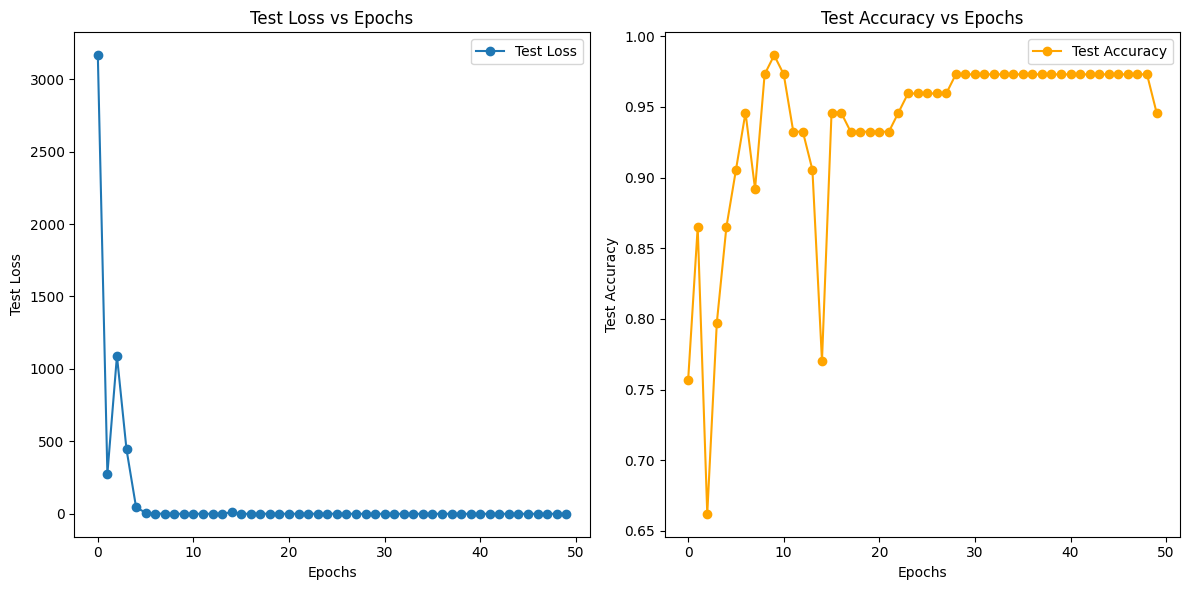

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['val_loss'], label='Test Loss', marker='o') # Val
plt.title('Test Loss vs Epochs') # Val
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Test Accuracy', marker='o', color='orange')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()

plt.tight_layout() # comparar test loss y training loss y lo mismo para accuracy

* Confusion Matrix

3/3 [==============================] - 0s 84ms/step


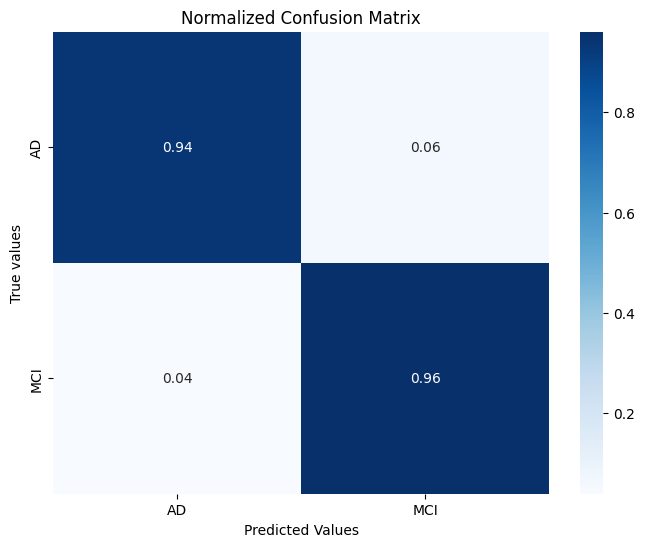

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the classes in the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the predicted classes

# Get the actual classes of the test set
y_true = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
confusion_mtx_normalized=confusion_mtx/confusion_mtx.sum(axis=1, keepdims=True)

# Represent the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["AD", "MCI"],
            yticklabels=["AD", "MCI"])
plt.xlabel('Predicted Values')
plt.ylabel('True values')
plt.title('Normalized Confusion Matrix')
plt.show()

* ROC (Receiver Operating Characteristic) curve:

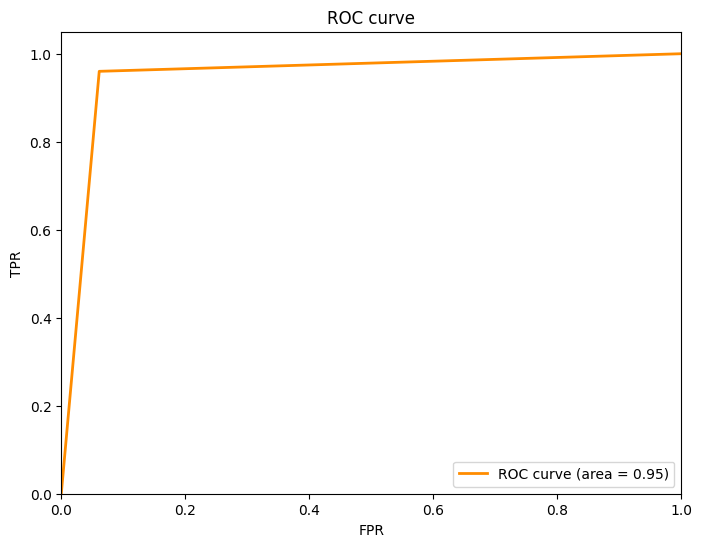

In [22]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = roc_curve(y_true, y_pred_classes)[0]
tpr = roc_curve(y_true, y_pred_classes)[1]
roc_auc=auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
